### Get all the imports

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

### Define all functions

In [13]:
# This function generates a vector which will represent the given profession
def gen_typical_prof(df_train, prof_ind):
    profession = df_train["Profession"].values
    prof_inds = np.where(profession==prof_ind)[0]
    
    # Create aggregated results for each feature
    gender = Counter(df_train["Gender"].values[prof_inds]).most_common(1)[0][0]
    ever_married = Counter(df_train["Ever_Married"].values[prof_inds]).most_common(1)[0][0]
    age = [i for i in df_train["Age"].values[prof_inds] if i!=-999]
    graduated = Counter(df_train["Graduated"].values[prof_inds]).most_common(1)[0][0]
    work_exp = [i for i in df_train["Work_Experience"].values[prof_inds] if i!=-999]
    spend_score = Counter(df_train["Spending_Score"].values[prof_inds]).most_common(1)[0][0]
    family_size = [i for i in df_train["Family_Size"].values[prof_inds] if i!=-999]
    var1 = Counter(df_train["Var_1"].values[prof_inds]).most_common(1)[0][0]

    # Finally return the vector
    return np.array([gender, ever_married, sum(age)/len(age), graduated, sum(work_exp)/len(work_exp), spend_score, sum(family_size)/len(family_size), var1])

### Load data, preprocess and perform feature engineering

In [14]:
# Loads the data
df_train = pd.read_csv("../Data/Train.csv")
df_test = pd.read_csv("../Data/Test.csv")

# Some global variables
fill_na_val = "JAJA"
seg_mapping = dict()

# Convert Numeric NaNs to -999
features = ["Age", "Work_Experience", "Family_Size"]
df_train[features] = df_train[features].fillna(-999)
df_test[features] = df_test[features].fillna(-999)

# NaN in gender could mean that person is a transgender and does not want to disclose
gender_mapping = {"Male": 0, "Female": 1}
df_train["Gender"] = df_train["Gender"].fillna(2)
df_test["Gender"] = df_test["Gender"].fillna(2)
for gender, label in gender_mapping.items():
    df_train["Gender"] = df_train["Gender"].replace(gender, label)
    df_test["Gender"] = df_test["Gender"].replace(gender, label)

# Nan in ever_married could mean that the person does not want to reveal
# In that case it gives us extra info about the person type
married_mapping = {"Yes": 0, "No": 1}
df_train["Ever_Married"] = df_train["Ever_Married"].fillna(2)
df_test["Ever_Married"] = df_test["Ever_Married"].fillna(2)
for married, label in married_mapping.items():
    df_train["Ever_Married"] = df_train["Ever_Married"].replace(married, label)
    df_test["Ever_Married"] = df_test["Ever_Married"].replace(married, label)
    
# Nan in graduated could mean that the person has not graduate and does not want to reveal
grad_mapping = {"Yes": 0, "No": 1}
df_train["Graduated"] = df_train["Graduated"].fillna(1)
df_test["Graduated"] = df_test["Graduated"].fillna(1)
for grad, label in grad_mapping.items():
    df_train["Graduated"] = df_train["Graduated"].replace(grad, label)
    df_test["Graduated"] = df_test["Graduated"].replace(grad, label)

# Nan in profession could mean that person is unemployed
prof_mapping = {"Artist": 0, "Doctor": 1, "Engineer": 2, "Entertainment": 3, "Executive": 4, "Healthcare": 5, "Homemaker": 6, "Lawyer": 7, "Marketing": 8}
df_train["Profession"] = df_train["Profession"].fillna(9)
df_test["Profession"] = df_test["Profession"].fillna(9)
for prof, label in prof_mapping.items():
    df_train["Profession"] = df_train["Profession"].replace(prof, label)
    df_test["Profession"] = df_test["Profession"].replace(prof, label)

# Spending score is nan means it could be low
ss_mapping = {"Low": 0, "Average": 1, "High": 2}
df_train["Spending_Score"] = df_train["Spending_Score"].fillna(ss_mapping["Low"])
df_test["Spending_Score"] = df_test["Spending_Score"].fillna(ss_mapping["Low"])
for ss, label in ss_mapping.items():
    df_train["Spending_Score"] = df_train["Spending_Score"].replace(ss, label)
    df_test["Spending_Score"] = df_test["Spending_Score"].replace(ss, label)

# NaN in Var1 is just another category
var1_mapping = {"Cat_1": 0, "Cat_2": 1, "Cat_3": 2, "Cat_4": 3, "Cat_5": 4, "Cat_6": 5, "Cat_7": 6}
df_train["Var_1"] = df_train["Var_1"].fillna(7)
df_test["Var_1"] = df_test["Var_1"].fillna(7)
for var1, label in var1_mapping.items():
    df_train["Var_1"] = df_train["Var_1"].replace(var1, label)
    df_test["Var_1"] = df_test["Var_1"].replace(var1, label)

# Finally label encode segmentation
seg_mapping = {"A": 0, "B": 1, "C": 2, "D": 3}
seg_mapping_rev = {0: "A", 1: "B", 2: "C", 3: "D"}
for seg, label in seg_mapping.items():
    df_train["Segmentation"] = df_train["Segmentation"].replace(seg, label)

# Based on EDA, bin the Age feature (Didn't help)
# 1 -> young, 2 -> middle-aged, 3 -> old, 4 -> retired and old
df_train["Age_group"] = [1 if i<=33 else 2 if i>33 and i<65 else 3 if i>=65 and i<74 else 4 for i in df_train["Age"].values]
df_test["Age_group"] = [1 if i<=33 else 2 if i>33 and i<65 else 3 if i>=65 and i<74 else 4 for i in df_test["Age"].values]

# Based on EDA, Create Lonely feature :P
df_train["Lonely"] = [1 if members<2 and age >= 60 and gender == 1 else 0 for members, age, gender in zip(df_train["Family_Size"].values, df_train["Age"].values, df_train["Gender"].values)]
df_test["Lonely"] = [1 if members<2 and age >= 60 and gender == 1 else 0 for members, age, gender in zip(df_test["Family_Size"].values, df_test["Age"].values, df_test["Gender"].values)]

# Bin the ID column and add as feature
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_train["Binned_ID"] = est.fit_transform(np.reshape(df_train["ID"].values, (-1,1)))
df_test["Binned_ID"] = est.transform(np.reshape(df_test["ID"].values, (-1,1)))

df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_group,Lonely,Binned_ID
0,462809,0,1,22,1,5,1.0,0,4.0,3,3,1,0,4.0
1,462643,1,0,38,0,2,-999.0,1,3.0,3,0,2,0,4.0
2,466315,1,0,67,0,2,1.0,0,1.0,5,1,3,1,8.0
3,461735,0,0,67,0,7,0.0,2,2.0,5,1,3,0,3.0
4,462669,1,0,40,0,3,-999.0,2,6.0,5,0,2,0,4.0


### Specify which features are cat features and generate the train and test for CV

In [15]:
# Drop the columns specified
cols_to_remove = ["ID", "Segmentation"]
df_train_dum, Y = df_train.drop(cols_to_remove, axis=1), df_train[cols_to_remove[-1]].values
df_test_dum = df_test.drop(cols_to_remove[:-1], axis=1)

# Specify which features are to be treated as Categorical features
cat_feats = ['Gender', 'Ever_Married', 'Graduated', "Var_1", 'Profession', 'Age_group', 'Lonely', "Binned_ID"]
cat_feats_inds = [df_train_dum.columns.get_loc(c) for c in cat_feats]

### Create 2 CVs for better validation

In [16]:
# CV: 1
kfold = KFold(n_splits=5, random_state=27, shuffle=True)
scores = list()
for train, test in kfold.split(df_train_dum):
    x_train, x_test = df_train_dum.iloc[train], df_train_dum.iloc[test]
    y_train, y_test = Y[train], Y[test]
    
    model = LGBMClassifier(random_state=100, max_depth=3, n_estimators=200, learning_rate=0.1)
    model.fit(x_train, y_train, categorical_feature=cat_feats_inds)
    preds = model.predict(x_test)
    
    score = accuracy_score(y_test, preds)
    scores.append(score)
    print("Score: ", score)
first_fold = sum(scores)/len(scores)
print("\nAverage Score: ", first_fold, "\n\n")

# CV: 2
kfold = StratifiedKFold(n_splits=10, random_state=27, shuffle=True)
scores = list()
for train, test in kfold.split(df_train_dum, Y):
    x_train, x_test = df_train_dum.iloc[train], df_train_dum.iloc[test]
    y_train, y_test = Y[train], Y[test]
    
    model = LGBMClassifier(random_state=100, max_depth=3, n_estimators=200, learning_rate=0.1)
    model.fit(x_train, y_train, categorical_feature=cat_feats_inds)
    preds = model.predict(x_test)
    
    score = accuracy_score(y_test, preds)
    scores.append(score)
    print("Score: ", score)
    
second_fold = sum(scores)/len(scores)
print("\nAverage Score: ", second_fold)
print("\n\nFinal Average: ", first_fold*0.5 + second_fold*0.5)

Score:  0.5520446096654275
Score:  0.5433705080545229
Score:  0.557001239157373
Score:  0.5288282703037818
Score:  0.5226286422814631

Average Score:  0.5407746538925137 


Score:  0.5514250309789344
Score:  0.5514250309789344
Score:  0.5625774473358116
Score:  0.5229244114002478
Score:  0.5340768277571252
Score:  0.530359355638166
Score:  0.5588599752168525
Score:  0.550185873605948
Score:  0.5384615384615384
Score:  0.5310173697270472

Average Score:  0.5431312861100606


Final Average:  0.5419529700012871


In [6]:
# No Augmentation:
# ----------------
# Average Score:  0.5407746538925137
# Average Score:  0.5431312861100606
# Final Average:  0.5419529700012871

In [7]:
# With Augmentation:
# ----------------
# Average Score:  0.5514423076923076 
# Average Score:  0.5532692307692308
# Average Score_Final: 0.5523557692307692

### Time for the final submission

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Age_group,Lonely,Binned_ID
0,0,1,22,1,5,1.0,0,4.0,3,1,0,4.0
1,1,0,38,0,2,-999.0,1,3.0,3,2,0,4.0
2,1,0,67,0,2,1.0,0,1.0,5,3,1,8.0
3,0,0,67,0,7,0.0,2,2.0,5,3,0,3.0
4,1,0,40,0,3,-999.0,2,6.0,5,2,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8063,0,1,22,1,9,0.0,0,7.0,0,1,0,5.0
8064,0,1,35,1,4,3.0,0,4.0,3,2,0,6.0
8065,1,1,33,0,5,1.0,0,1.0,5,1,0,7.0
8066,1,1,27,0,5,1.0,0,4.0,5,1,0,9.0


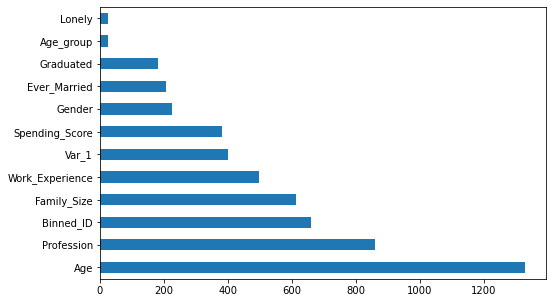

In [17]:
# Generate the train and test
X_train, X_test = df_train.drop(cols_to_remove, axis=1), df_test.drop(cols_to_remove[:-1], axis=1)
display(X_train)

# Perform traing and prediction
model = LGBMClassifier(random_state=27, max_depth=3, n_estimators=200, learning_rate=0.1)
model.fit(X_train.values, Y, categorical_feature=cat_feats_inds)
preds = [seg_mapping_rev[i] for i in model.predict(X_test.values)]

# Let's the feature importances
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,5))

# Use Leak to replace all test IDs in train with corresponding class in train
new_preds, tmp = list(), list(df_train["ID"].values)
for index, val in enumerate(zip(df_test["ID"].values, preds)):
    id_, pred = val[0], val[1]
    if id_ in tmp:
        new_preds.append(seg_mapping_rev[Y[tmp.index(id_)]])
    else:
        new_preds.append(pred)

# Finally, make a submission
df_submit = pd.DataFrame({'ID': df_test["ID"].values, 'Segmentation': np.array(new_preds)})
df_submit.to_csv("submit.csv", index=False)